# Plotting temperature and photosynthesis-related GO term counts, normalised by number of InterPro annotations, for Tara Oceans project ERP009703.


This task shows how to analysie metadata and annotations retrieved from the EMG API and combined on the fly to generate the visualisations.

In [19]:
from jsonapi_client import Session, Filter

metadata_key = 'temperature'
normilize_meta_key = 'Total InterProScan matches'

result = {}

with Session('https://www.ebi.ac.uk/metagenomics/api/v0.2/') as s:

    run_meta_mapping = {}
    missing_temp = list()
    
    print('Loading data from API.', end='', flush=True)
    # list samples
    f = Filter('study_accession=ERP009703')
    for anls in s.iterate('pipelines/2.0/analysis', f):
        print('.', end='', flush=True)
        for m in anls.sample.metadata:
            if m.var_name.lower() == metadata_key.lower():
                m_value = int(float(m.var_value))
                run_meta_mapping[anls.accession] = m_value
        # if missing
        try:
            run_meta_mapping[anls.accession]
        except KeyError:
            missing_temp.append(anls.accession)

        for _m in anls.metadata:
            if _m.var_name.lower() == normilize_meta_key.lower():
                ipr_count = _m.var_value

        _key = run_meta_mapping[anls.accession]
        try:
            result[_key]
        except KeyError:
            result[_key] = {}

        rt = "runs/%s/pipelines/%s/go-slim" % (anls.accession, anls.pipeline_version)
        _f = Filter('page_size=100')
        for a in s.iterate(rt, _f):
            try:
                result[_key][a.accession]
            except KeyError:
                result[_key][a.accession] = list()
            _z = float(a.count)/int(ipr_count)
            result[_key][a.accession].append(_z)
    print("DONE")
    print("Missing: ", missing_temp)

Loading data from API.......................................................................................................................................................DONE
Missing:  []


In [20]:
print(result)

{20: {'GO:0000015': [0.0001144076840981857, 0.00016615490330629482, 0.0001509377341656046, 1.1798087530011386e-05, 0.00014863839407949807, 0.00012626657538404153, 6.189395502372602e-05, 7.736623240263597e-05, 5.723132903194713e-05, 9.2784641049085e-05, 7.856230973190612e-05], 'GO:0000150': [0.00022540021344717183, 0.00010044392459759066, 0.00013218215773082534, 9.438470024009109e-05, 9.778841715756452e-05, 0.00011468248589926708, 0.0002682071384361461, 0.0001878894215492588, 0.00020784008964233432, 0.00011018176124578845, 0.00016618950135595525], 'GO:0000156': [4.610458911419424e-05, 6.571097870870417e-06, 8.038104186333973e-06, 2.3596175060022772e-05, 2.0861528993613764e-05, 1.3900907381729342e-05, 0.00012084057885584603, 7.736623240263597e-05, 7.53043803051936e-05, 2.319616026227125e-05, 7.554068243452512e-06], 'GO:0000160': [0.0019620064034151547, 0.001609918978363252, 0.001418278827544261, 0.0010913230965260532, 0.0014694339484876695, 0.0015777529878262804, 0.0036016387161425327, 0

### Clean up data
remove invalid values and calculate average of counts

In [21]:
import numpy as np
import copy

for k in result.keys():
    if k > 1000:
        del result[k]
for k in result:
    for k1 in result[k]:
        result[k][k1] = np.mean(result[k][k1])

### Plot

     GO:0009579  GO:0015979
-1     0.001304    0.001851
 0     0.000000    0.000000
 7     0.000656    0.001051
 9     0.000590    0.001130
 10    0.001171    0.001762
 11    0.000424    0.000817
 12    0.000760    0.001479
 13    0.001116    0.001692
 14    0.000820    0.001641
 15    0.000817    0.001426
 16    0.001217    0.001892
 17    0.000912    0.001831
 18    0.000717    0.001386
 19    0.000780    0.001382
 20    0.000849    0.001409
 21    0.000616    0.001199
 22    0.000429    0.001125
 23    0.000932    0.001716
 24    0.000870    0.001596
 25    0.000534    0.001072
 26    0.001090    0.002069
 27    0.001457    0.002386
 28    0.002029    0.002867
 29    0.000850    0.001338
 30    0.000832    0.002109
 31    0.000482    0.001543


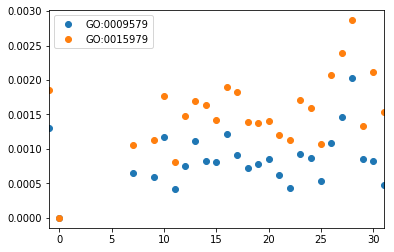

In [22]:
import matplotlib.pyplot as plt
from pandas import DataFrame

df = DataFrame(result).T.fillna(0)

print(df[['GO:0009579', 'GO:0015979']])
df.plot(y=['GO:0009579', 'GO:0015979'], use_index=True, style='o')

plt.show()

### Calculate correlation

In [23]:
from scipy.stats import spearmanr
df = DataFrame(result).T.fillna(0)
x = df.index.tolist()
correl = []
correl_p = []
for k in df.keys():
    y = list(df[k])
    rho, p = spearmanr(x, y)

    correl.append(rho)
    correl_p.append(p)
df.loc['rho'] = correl
df.loc['p'] = correl_p

/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3003: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3004: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [24]:
print(df[['GO:0009579','GO:0015979']])

     GO:0009579  GO:0015979
-1     0.001304    0.001851
0      0.000000    0.000000
7      0.000656    0.001051
9      0.000590    0.001130
10     0.001171    0.001762
11     0.000424    0.000817
12     0.000760    0.001479
13     0.001116    0.001692
14     0.000820    0.001641
15     0.000817    0.001426
16     0.001217    0.001892
17     0.000912    0.001831
18     0.000717    0.001386
19     0.000780    0.001382
20     0.000849    0.001409
21     0.000616    0.001199
22     0.000429    0.001125
23     0.000932    0.001716
24     0.000870    0.001596
25     0.000534    0.001072
26     0.001090    0.002069
27     0.001457    0.002386
28     0.002029    0.002867
29     0.000850    0.001338
30     0.000832    0.002109
31     0.000482    0.001543
rho    0.158291    0.336068
p      0.439925    0.093236
